
<h1><center>Lesson 2 — Modern Portfolio Theory (Crypto)</center></h1>

This notebook adapts the original Markowitz portfolio lesson to crypto. We will:
- Acquire crypto prices
- Compute returns, covariance, and correlation
- Explore risk vs. return
- Approximate the efficient frontier with random portfolios (no shorting)
- Identify minimum-variance and maximum-Sharpe portfolios
- Visualize weights and discuss trade‑offs


### Why this matters
Markowitz’s Modern Portfolio Theory (MPT) formalizes the trade‑off between risk and return when combining multiple assets. Even simple equal‑weight portfolios can be improved by considering the covariance between assets: assets that do not move together can reduce overall portfolio risk for a given expected return.


### Table of contents
1. Data acquisition (crypto)
2. Returns, covariance, and correlation
3. Random portfolios and the efficient frontier (approximation)
4. Minimum-variance and maximum-Sharpe portfolios
5. Weight visualization and interpretation


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

try:
    import yfinance as yf
except Exception:
    yf=None

import warnings as wrn
wrn.filterwarnings('ignore', category=FutureWarning)
wrn.filterwarnings('ignore', category=UserWarning)


### 1. Data acquisition (crypto)
We’ll pull daily closes for a small crypto universe and align them to the same dates (inner join) to avoid missing data issues when computing covariances.


In [3]:
symbols = ['BTC-USD','ETH-USD','BNB-USD','ADA-USD','XRP-USD']
start_date = (pd.Timestamp.now() - pd.Timedelta(days=365*2)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

prices = pd.DataFrame()

if yf is not None:
    try:
        # Download all symbols at once for efficiency and aligned dates
        data = yf.download(
            symbols,
            start=start_date,
            end=end_date,
            interval='1d',
            progress=False
        )
        if not data.empty and 'Close' in data.columns:
            close = data['Close']
            # Drop tickers with no data, then drop any rows with missing data (align universe)
            close = close.dropna(axis=1, how='all')
            close = close.dropna(axis=0, how='any')
            prices = close.sort_index()
        if not prices.empty:
            print(f"Successfully downloaded data for: {list(prices.columns)}")
        else:
            print("No valid, overlapping data found for the requested symbols.")
    except Exception as e:
        print(f"An error occurred during data download: {e}")
else:
    print("yfinance module 'yf' is not available.")

prices.tail()


Successfully downloaded data for: ['ADA-USD', 'BNB-USD', 'BTC-USD', 'ETH-USD', 'XRP-USD']


Ticker,ADA-USD,BNB-USD,BTC-USD,ETH-USD,XRP-USD
Date,,,,,
2025-08-02,0.697670,736.646423,112526.914062,3392.741211,2.766372
2025-08-03,0.726976,751.560974,114217.671875,3497.379150,2.949544
2025-08-04,0.754808,769.059082,115071.882812,3718.986084,3.072810
2025-08-05,0.726036,754.851013,114141.445312,3611.899414,2.963748
2025-08-07,0.786395,788.196350,117496.898438,3914.325928,3.318208


### 2. Returns, covariance, correlation
We work with log returns for stability and add a small constant to avoid issues with zero/negative prices (not typical for spot but safe practice). Covariance captures co‑movement between assets and is the backbone of portfolio risk.


In [4]:
eps = 1e-9
log_prices = np.log(prices + eps)
log_returns = log_prices.diff().dropna()

mu = log_returns.mean()   # expected return per period
C = log_returns.cov()     # covariance matrix
P = log_returns.corr()    # correlation matrix

mu, C.head(), P.head()


(Ticker
 ADA-USD    0.001358
 BNB-USD    0.001640
 BTC-USD    0.001908
 ETH-USD    0.001034
 XRP-USD    0.002285
 dtype: float64,
 Ticker    ADA-USD   BNB-USD   BTC-USD   ETH-USD   XRP-USD
 Ticker                                                   
 ADA-USD  0.002225  0.000675  0.000810  0.001143  0.001434
 BNB-USD  0.000675  0.000728  0.000428  0.000586  0.000475
 BTC-USD  0.000810  0.000428  0.000641  0.000686  0.000602
 ETH-USD  0.001143  0.000586  0.000686  0.001185  0.000833
 XRP-USD  0.001434  0.000475  0.000602  0.000833  0.001757,
 Ticker    ADA-USD   BNB-USD   BTC-USD   ETH-USD   XRP-USD
 Ticker                                                   
 ADA-USD  1.000000  0.530859  0.678830  0.703970  0.725358
 BNB-USD  0.530859  1.000000  0.626495  0.630592  0.419781
 BTC-USD  0.678830  0.626495  1.000000  0.787485  0.567185
 ETH-USD  0.703970  0.630592  0.787485  1.000000  0.577505
 XRP-USD  0.725358  0.419781  0.567185  0.577505  1.000000)

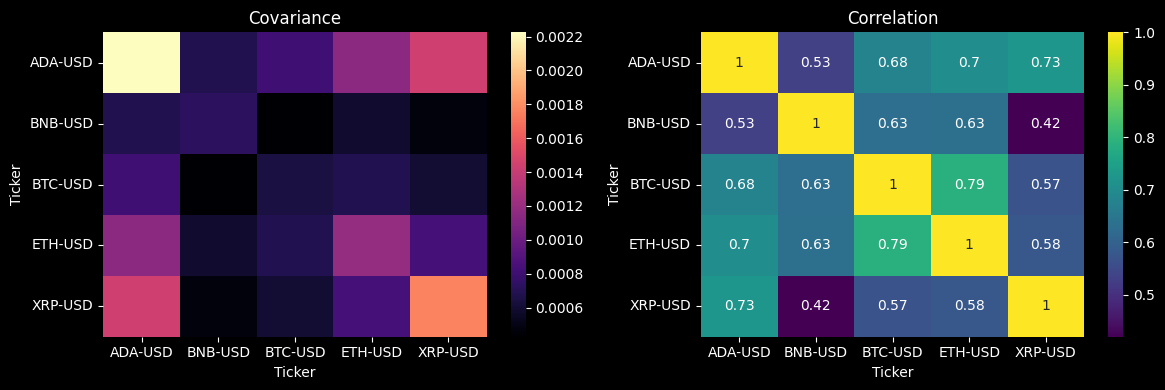

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(C, annot=False, cmap='magma', ax=ax[0])
ax[0].set_title('Covariance')
sns.heatmap(P, annot=True, cmap='viridis', ax=ax[1])
ax[1].set_title('Correlation')
plt.tight_layout()


### 3. Random portfolios and the efficient frontier
We approximate the efficient frontier by sampling many random weight vectors (that sum to 1, no shorts) and computing their expected return and volatility. This reveals the risk–return envelope attainable by diversification.


In [10]:
rng = np.random.default_rng(0)
N = len(mu)
ports = 10000
weights = []
port_mu = []
port_sig = []

for _ in range(ports):
    w = rng.random(N)
    w = w/np.sum(w)
    m = float(np.dot(w, mu.values))
    s = float(np.sqrt(np.dot(w, np.dot(C.values, w))))
    weights.append(w)
    port_mu.append(m)
    port_sig.append(s)

frontier = pd.DataFrame({'risk': port_sig, 'return': port_mu})
frontier.head()


,risk,return
0,0.036416,0.001834
1,0.030909,0.001697
2,0.033389,0.001825
3,0.026309,0.001721
4,0.028705,0.001725


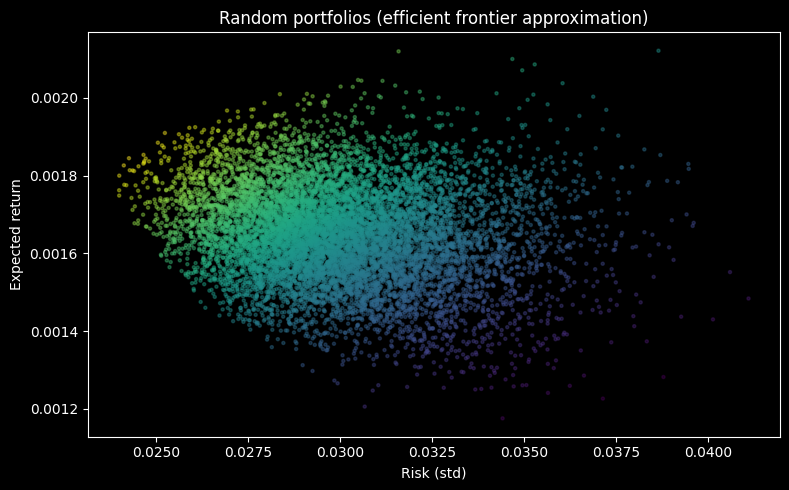

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(frontier['risk'], frontier['return'], s=5, alpha=0.4, c=frontier['return']/frontier['risk'], cmap='viridis')
ax.set_xlabel('Risk (std)')
ax.set_ylabel('Expected return')
ax.set_title('Random portfolios (efficient frontier approximation)')
plt.tight_layout()


### 4. Minimum-variance and maximum-Sharpe portfolios
We pick (a) the lowest-risk portfolio on the cloud and (b) the highest Sharpe (return/risk) portfolio as practical references. In production, you may add constraints (min/max weight, turnover) or use dedicated optimizers (e.g., PyPortfolioOpt).


In [12]:
frontier['sharpe'] = frontier['return']/frontier['risk'].replace(0, np.nan)
min_var_idx = frontier['risk'].idxmin()
max_sharpe_idx = frontier['sharpe'].idxmax()

w_min_var = weights[min_var_idx]
w_max_sharpe = weights[max_sharpe_idx]

print('Min-variance risk/return:', frontier.loc[min_var_idx, ['risk','return']].to_dict())
print('Max-Sharpe risk/return:', frontier.loc[max_sharpe_idx, ['risk','return']].to_dict())


Min-variance risk/return: {'risk': 0.02399838568795269, 'return': 0.0017625229820131048}
Max-Sharpe risk/return: {'risk': 0.024265801078970934, 'return': 0.0018449843115766822}


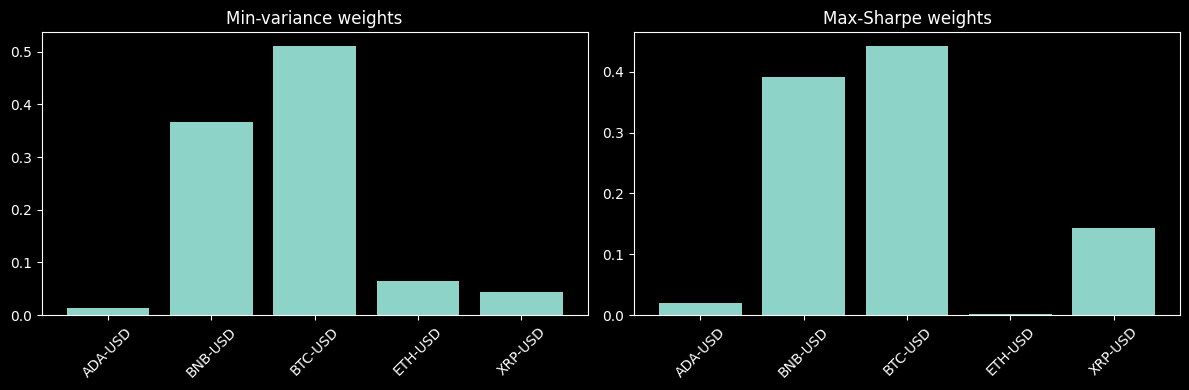

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(prices.columns, w_min_var)
ax[0].set_title('Min-variance weights')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(prices.columns, w_max_sharpe)
ax[1].set_title('Max-Sharpe weights')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()


### 5. Interpretation
- The efficient frontier (the upper‑left envelope of points) shows the best expected return for each level of risk.
- Minimum‑variance portfolios reduce risk but may sacrifice return.
- Maximum‑Sharpe portfolios balance return per unit of risk, often favoring assets with higher standalone return and/or diversification benefits.
- In crypto, correlations can be high; consider adding stablecoins or regime filters, and review rebalancing costs and liquidity.
